In [17]:
import importlib

import pandas as pd
import numpy as np
import yfinance as yf

import plotly.express as px
import matplotlib.pyplot as plt

#### **Context**

In this notebook, we focus on quoting based on high frequency price data. We have to major sources of data:
1. yfinance 7 days 1minute data
2. LOBSTER 1 day 1 sec data

## **Prepare Data :**



#### yFinance data

In [84]:
df = yf.download("SPY", interval="1m", period="7d")

C:\Users\Massil\AppData\Local\Temp\ipykernel_12340\731914263.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("SPY", interval="1m", period="7d")
[*********************100%***********************]  1 of 1 completed


In [85]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Datetime,,,,,
2025-11-19 14:30:00+00:00,660.585022,661.000000,660.200012,660.780029,2024847
2025-11-19 14:31:00+00:00,660.659973,660.880005,660.320007,660.585022,352441
2025-11-19 14:32:00+00:00,660.344971,660.640015,660.109985,660.640015,357962
2025-11-19 14:33:00+00:00,661.090027,661.104980,660.299988,660.299988,426945
2025-11-19 14:34:00+00:00,661.400024,661.609985,661.039978,661.070007,404588


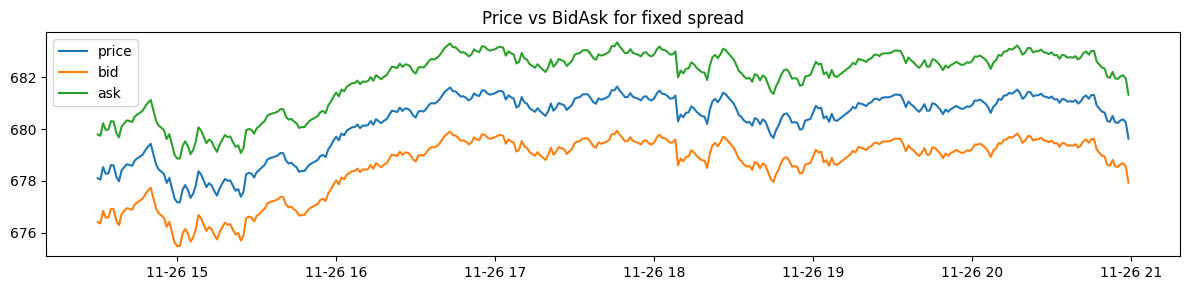

In [58]:
spread_bps = 50         # 50 basis points total spread = 0.50%
half_spread = spread_bps / 10000 / 2 # 0.005

df_prices = df[['Close','Volume']].copy()
df_prices.columns = ['price','volume']

df_prices = (
    df_prices.loc['2025-11-26']
    .assign(logprice=lambda df : np.log(df['price']))
    .assign(logret=lambda df : df['logprice'].diff())
    .assign(bid=lambda df : df['price'] * (1 - half_spread))
    .assign(ask=lambda df : df['price'] * (1 + half_spread))
)

fig = plt.figure(figsize=(12,3))
plt.plot(df_prices['price'],label='price')
plt.plot(df_prices['bid'],label='bid')
plt.plot(df_prices['ask'],label='ask')
plt.title('Price vs BidAsk for fixed spread')
plt.tight_layout()
plt.legend()
plt.show()

#### 2. LOBSTER Data

We know take some real high frequency market data, especially the foster dataset for MSFT prices on the 2012-06-21 day.

In [103]:
# Data Import
columns_ob = ['Ask','AskVolume','Bid','BidVolume']
df_ob = pd.read_csv('data/AMZN_2012-06-21_34200000_57600000_orderbook_1.csv',header=None,sep=';')
df_ob.columns = columns_ob

df_desc = pd.read_csv('data/AMZN_2012-06-21_34200000_57600000_message_1.csv',header=None)
df_desc.columns = ['Time','Type','OrderID','Size','Price','Direction']

raw_data = pd.concat([df_ob,df_desc],axis=1)
raw_data.head()

,Ask,AskVolume,Bid,BidVolume,Time,Type,OrderID,Size,Price,Direction
0,2239500,100,2231800,100,34200.017460,5,0,1,2238200,-1
1,2239500,100,2238100,21,34200.189608,1,11885113,21,2238100,1
2,2239500,100,2237500,100,34200.190226,4,11885113,21,2238100,1
3,2239500,100,2237500,74,34200.190226,4,11534792,26,2237500,1
4,2239500,100,2237500,74,34200.372780,5,0,100,2238400,-1


In [271]:
# Processing
df_prices = ( 
    raw_data.copy()
    .assign(Time = lambda df : pd.to_datetime(data['Time'], unit='s'))
    .assign(Ask=lambda df : df['Ask']/10000)
    .assign(Bid=lambda df : df['Bid']/10000)
    .assign(price=lambda df : df['Price']/10000)
    .assign(mid=lambda df : (df['Ask']+df['Bid'])/2)
    .assign(logprice=lambda df : np.log(df['mid']))    
    .assign(logret=lambda df : df['logprice'].diff())    
    .assign(spread=lambda df : df['Ask']-df['Bid'])
    .assign(volumespread=lambda df : df['AskVolume']-df['BidVolume'])
    .assign(volume=lambda df : df['AskVolume']+df['BidVolume'])
    .set_index('Time')
)

df_resample = HF.resample(df_prices,10)

#### Prepare data

Set it in the correct format for our MM purposes :
- creating price series 
- creating price_requests for any time of the grid

In [241]:
from trading.trades import QuotedTrade, CompletedTrade
from trading.market_maker import MarketMaker,Position
from trading.hedge_fund import HedgeFund
from trading.exchange import ExchangeTrade, Exchange
import utils.visu as visu
import utils.pnl as pnl
import utils.HF as HF
import utils.quotes as quotes

modules_to_reload = ['utils','trading.market_maker','utils.HF']  # your own files
for m in modules_to_reload:
    importlib.reload(sys.modules[m])

In [219]:
ticker = "MSFT"   # or your ETF
df = df_resample.copy()


# "prices": list of (ticker, timestamp, price)
prices = [(ticker, ts, float(row["price"])) for ts, row in df.iterrows()]

# "price_requests": list of [ticker, timestamp, volume]
# here: yfinance based volume + uniform random 
default_volume = 1000
df['random_volume'] = (
    df['volume'] * np.random.uniform(0.6, 1.4, len(df['volume']))/100).astype(int) 

price_requests = [[ticker, ts, row['random_volume']] for ts ,row in df.iterrows()]

In [220]:
# map HF action -> MM action
mm_dict = {
    "buy": "sell",   # client buys, MM sells
    "sell": "buy"    # client sells, MM buys
}

# join requests with prices (like request_with_prices in the notebook)
test_requests = []
request_with_prices = []

quote_every = 1

for idx in range(0, len(price_requests)):
    if idx % quote_every != 0:
        continue
    else :
        test_requests.append(price_requests[idx])

for price in prices:
    for request in test_requests:
        if price[0] == request[0] and price[1] == request[1]:
            request_with_prices.append((request, price[2]))

## **Quote prices (fixed spread)**

Quote with our fixed bid ask spread, we use the shifted price as a price request.

$$Bid = Ref - Spread$$
$$Ask = Ref + Spread$$

- send "buy" if price request < bid
- send "sell" if price request > ask 

In [76]:
def fixed_quote(current_price, base_spread):
    """
    Compute fixed quote based on inventory.
    
    Args:
        current_price (float): current mid/close price
        base_spread (float): base spread (as fraction of price, e.g. 0.02 = 2%)
        
    Returns:
        (bid_price, offer_price)
    """
    spread = current_price * base_spread  
    bid_price = current_price - spread
    offer_price = current_price + spread
    return bid_price, offer_price


*setting up the market maker*

In [77]:
# create market maker & hedge fund
mm = MarketMaker.mm()
hf = HedgeFund(seed=42)  # same interface as in the assessment

quoted_trades = []

for matched in request_with_prices:
    ticker = matched[0][0]
    trade_volume = matched[0][2]
    ref_price = matched[1]
    date = matched[0][1]
    current_price = matched[1]

    bid_price,offer_price = fixed_quote(current_price, 
                                        base_spread = 0.02) 
    
    # 3. Create quote
    qt = QuotedTrade(
        ticker=ticker,
        trade_volume=trade_volume,
        ref_price=ref_price,
        bid_price=bid_price,
        offer_price=offer_price,
        date=date
    )
    quoted_trades.append(qt)

    # 4. Log quote
    mm.add_quoted_trade(qt)

    # 5. Show quote to HF
    response = hf.show(qt)

    # 6. Process response -> CompletedTrade if not refused
    if response.hf_action != "refuse":
        ct = CompletedTrade(
            ticker=response.ticker,
            trade_volume=response.trade_volume,
            trade_price=response.trade_price,
            mm_action=mm_dict[response.hf_action],
            ref_price=response.ref_price,
            bid_price=response.bid_price,
            offer_price=response.offer_price,
            date=response.date
        )
        mm.add_trade(ct)


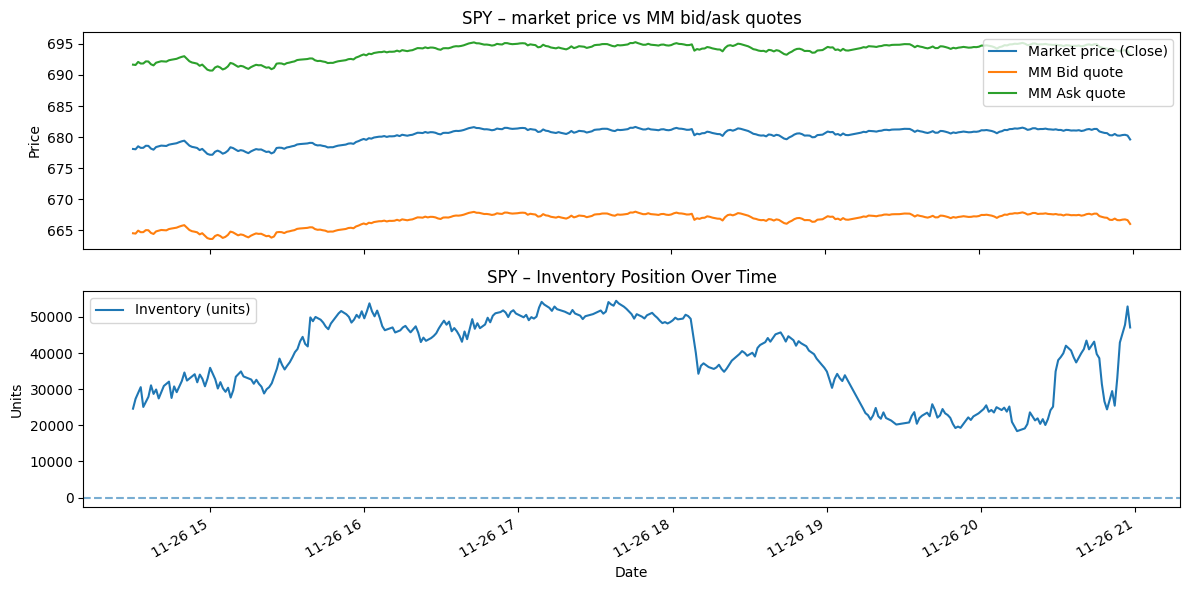

In [79]:
ticker_to_plot = "SPY"

quotes_plot_df = visu.get_quotes_df(mm,ticker_to_plot)
inventory_df = visu.get_inventory_df(mm,ticker_to_plot)

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12, 6))

ax1.plot(quotes_plot_df.index, quotes_plot_df["ref_price"], label="Market price (Close)")
ax1.plot(quotes_plot_df.index, quotes_plot_df["bid_price"], label="MM Bid quote")
ax1.plot(quotes_plot_df.index, quotes_plot_df["offer_price"], label="MM Ask quote")

ax1.set_title(f"{ticker} – market price vs MM bid/ask quotes")
ax1.set_ylabel("Price")
ax1.legend()

ax2.plot(inventory_df.index, inventory_df["inventory_volume"], label="Inventory (units)")
ax2.axhline(0, linestyle="--", alpha=0.6)

ax2.set_title(f"{ticker_to_plot} – Inventory Position Over Time")
ax2.set_xlabel("Date")
ax2.set_ylabel("Units")
ax2.legend()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()



## Squewed quotes

**skew definition** : 

$s_t = tanh( \lambda * \frac{q_t}{q^*} )$ with $\lambda$ sensitivity, $q^*$ inventory_ideal_size, $q_t$ current inventory

$Bid_t = Mid_t \times (1 - \frac{\Delta_t}{2} - s_t)$

$Bid_t = Mid_t \times (1 + \frac{\Delta_t}{2} + s_t)$

[]

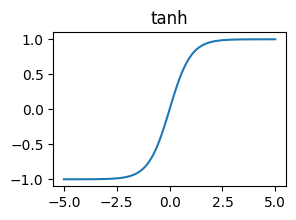

In [221]:
x = np.linspace(-5, 5, 100)
fig = plt.figure(figsize = (3,2))
plt.plot(x,np.tanh(x))
plt.title('tanh')
plt.plot()

In [222]:
# create market maker & hedge fund
mm = MarketMaker.mm()
hf = HedgeFund(seed=41)  # same interface as in the assessment


# 1–6: check risk, skew prices, quote, log, show to HF, log completed trades
quoted_trades = []

for matched in request_with_prices:
    ticker = matched[0][0]
    trade_volume = matched[0][2]
    ref_price = matched[1]
    date = matched[0][1]
    current_price = matched[1]

    # --- current inventory in $ ---
    # safely get current position (0 if not present yet)
    pos = mm.current_positions.get(ticker, Position(ticker, 0.0))
    current_volume = pos.position_volume
    current_inventory = current_volume * current_price

    # --- compute skewed bid/ask ---
    bid_price, offer_price = quotes.skewed_quote(
        current_price=current_price,
        base_spread=0.002,          # 2% base spread
        inventory=current_inventory,
        inventory_ideal_size=10_000_000,
        sensitivity=1.0,
        max_skew=0.02              # up to ±2% skew
    )

    # 3. Create quote
    qt = QuotedTrade(
        ticker=ticker,
        trade_volume=trade_volume,
        ref_price=ref_price,
        bid_price=bid_price,
        offer_price=offer_price,
        date=date
    )
    quoted_trades.append(qt)

    # 4. Log quote
    mm.add_quoted_trade(qt)

    # 5. Show quote to HF
    response = hf.show(qt)

    # 6. Process response -> CompletedTrade if not refused
    if response.hf_action != "refuse":
        ct = CompletedTrade(
            ticker=response.ticker,
            trade_volume=response.trade_volume,
            trade_price=response.trade_price,
            mm_action=mm_dict[response.hf_action],
            ref_price=response.ref_price,
            bid_price=response.bid_price,
            offer_price=response.offer_price,
            date=response.date
        )
        mm.add_trade(ct)


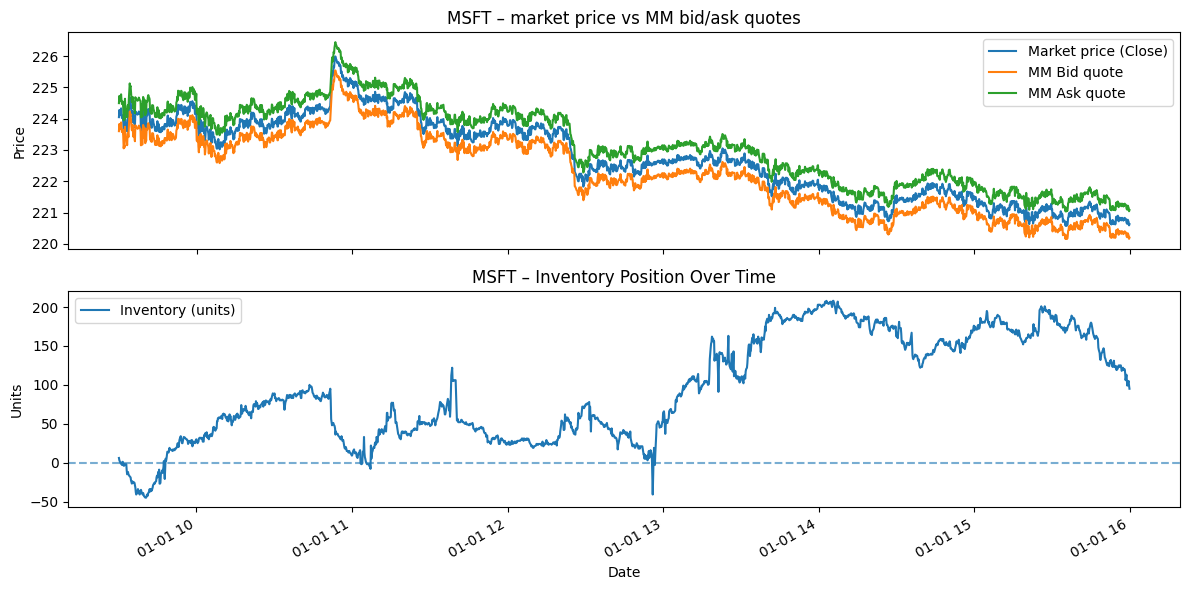

In [223]:
ticker_to_plot = "MSFT"

quotes_plot_df = visu.get_quotes_df(mm,ticker_to_plot)
inventory_df = visu.get_inventory_df(mm,ticker_to_plot)

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12, 6))

ax1.plot(quotes_plot_df.index, quotes_plot_df["ref_price"], label="Market price (Close)")
ax1.plot(quotes_plot_df.index, quotes_plot_df["bid_price"], label="MM Bid quote")
ax1.plot(quotes_plot_df.index, quotes_plot_df["offer_price"], label="MM Ask quote")

ax1.set_title(f"{ticker} – market price vs MM bid/ask quotes")
ax1.set_ylabel("Price")
ax1.legend()

ax2.plot(inventory_df.index, inventory_df["inventory_volume"], label="Inventory (units)")
ax2.axhline(0, linestyle="--", alpha=0.6)

ax2.set_title(f"{ticker_to_plot} – Inventory Position Over Time")
ax2.set_xlabel("Date")
ax2.set_ylabel("Units")
ax2.legend()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()



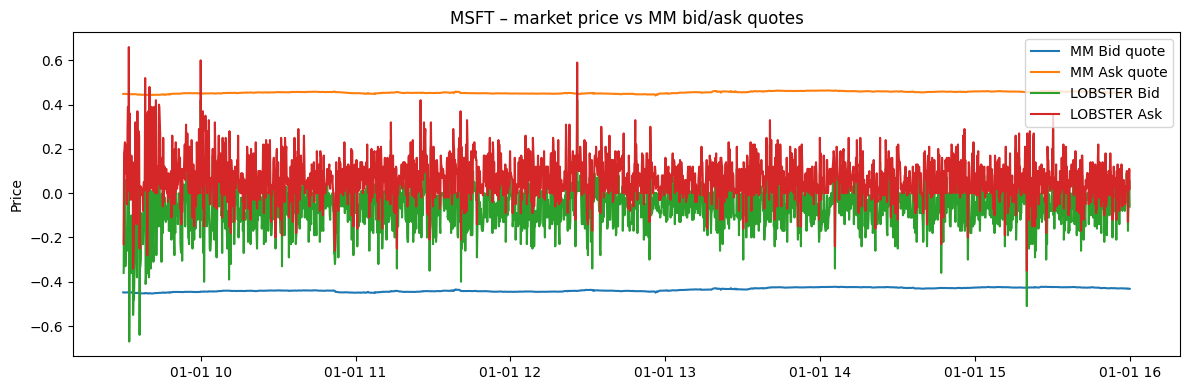

In [228]:
#all_quotes = pd.merge_asof(quotes_plot_df,df_prices[['Bid','Ask']],left_index = True, right_index=True)
all_quotes = pd.merge_asof(quotes_plot_df,df_prices[['Bid','Ask']],left_index = True, right_index=True)

(fig,ax) = plt.subplots(figsize = (12,4))

ax.plot(all_quotes.index, all_quotes["bid_price"]-all_quotes['ref_price'], label="MM Bid quote")
ax.plot(all_quotes.index, all_quotes["offer_price"]-all_quotes['ref_price'], label="MM Ask quote")
ax.plot(all_quotes.index, all_quotes["Bid"]-all_quotes['ref_price'], label="LOBSTER Bid")
ax.plot(all_quotes.index, all_quotes["Ask"]-all_quotes['ref_price'], label="LOBSTER Ask")

ax.set_title(f"{ticker} – market price vs MM bid/ask quotes")
ax.set_ylabel("Price")
ax.legend()
plt.tight_layout()
plt.show()


## Squewed quotes + spotvol

**skew definition** : 

$s_t = tanh( \lambda * \frac{q_t}{q^*} )$ with $\lambda$ sensitivity, $q^*$ inventory_ideal_size, $q_t$ current inventory

$Bid_t = Mid_t \times (1 - \frac{\Delta_t}{2} - s_t)$

$Bid_t = Mid_t \times (1 + \frac{\Delta_t}{2} + s_t)$

In [297]:
def vol_skewed_quote(current_price, base_spread, inventory,
                 inventory_ideal_size, sensitivity, max_skew,
                 sigma, k_sigma=1.0):
    """
    Compute skewed quote based on inventory and spot volatility.
    
    Args:
        current_price (float): current mid/close price
        base_spread (float): base spread (as fraction of price, e.g. 0.02 = 2%)
        inventory (float): current inventory in $ (position_volume * price)
        inventory_ideal_size (float): $ inventory level you're comfortable with
        sensitivity (float): how aggressively you react to inventory
        max_skew (float): max skew (as fraction of price, e.g. 0.02 = 2%)
        sigma (float): spot volatility estimate (e.g. realized vol)
        k_sigma (float): weighs how much vol impacts spread
    
    Returns:
        (bid_price, offer_price)
    """
    # inventory skew
    raw_skew = sensitivity * inventory / inventory_ideal_size
    skew = current_price * max_skew * np.tanh(raw_skew)

    # volatility-aware spread
    vol_component = k_sigma * sigma
    spread = max(current_price * base_spread, current_price * vol_component)

    bid_price = current_price + skew - spread / 2
    offer_price = current_price + skew + spread / 2
    return bid_price, offer_price


In [310]:
vol = HF.get_vol(df_resample.reset_index(), window_size=50, method='kernel').bfill()
vol.index = df_resample.index

<Axes: xlabel='Time'>

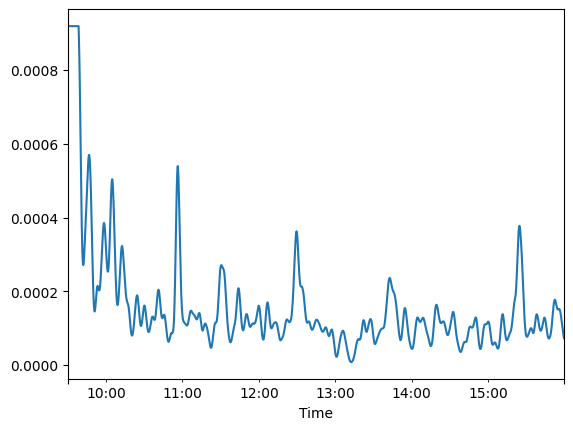

In [311]:
vol.plot()

In [312]:
# create market maker & hedge fund
mm = MarketMaker.mm()
hf = HedgeFund(seed=41)  # same interface as in the assessment


# 1–6: check risk, skew prices, quote, log, show to HF, log completed trades
quoted_trades = []

for matched in request_with_prices:
    ticker = matched[0][0]
    trade_volume = matched[0][2]
    ref_price = matched[1]
    date = matched[0][1]
    current_price = matched[1]

    # --- current inventory in $ ---
    # safely get current position (0 if not present yet)
    pos = mm.current_positions.get(ticker, Position(ticker, 0.0))
    current_volume = pos.position_volume
    current_inventory = current_volume * current_price

    # --- compute skewed bid/ask ---
    spot_vol = vol.loc[date]
    bid_price, offer_price = vol_skewed_quote(
                                    current_price=current_price, 
                                    base_spread=0.002, 
                                    inventory=current_inventory,
                                    inventory_ideal_size=10_000_000, 
                                    sensitivity=1.0, 
                                    max_skew=0.002,
                                    sigma=spot_vol, 
                                    k_sigma=15)


    # 3. Create quote
    qt = QuotedTrade(
        ticker=ticker,
        trade_volume=trade_volume,
        ref_price=ref_price,
        bid_price=bid_price,
        offer_price=offer_price,
        date=date
    )
    quoted_trades.append(qt)

    # 4. Log quote
    mm.add_quoted_trade(qt)

    # 5. Show quote to HF
    response = hf.show(qt)

    # 6. Process response -> CompletedTrade if not refused
    if response.hf_action != "refuse":
        ct = CompletedTrade(
            ticker=response.ticker,
            trade_volume=response.trade_volume,
            trade_price=response.trade_price,
            mm_action=mm_dict[response.hf_action],
            ref_price=response.ref_price,
            bid_price=response.bid_price,
            offer_price=response.offer_price,
            date=response.date
        )
        mm.add_trade(ct)


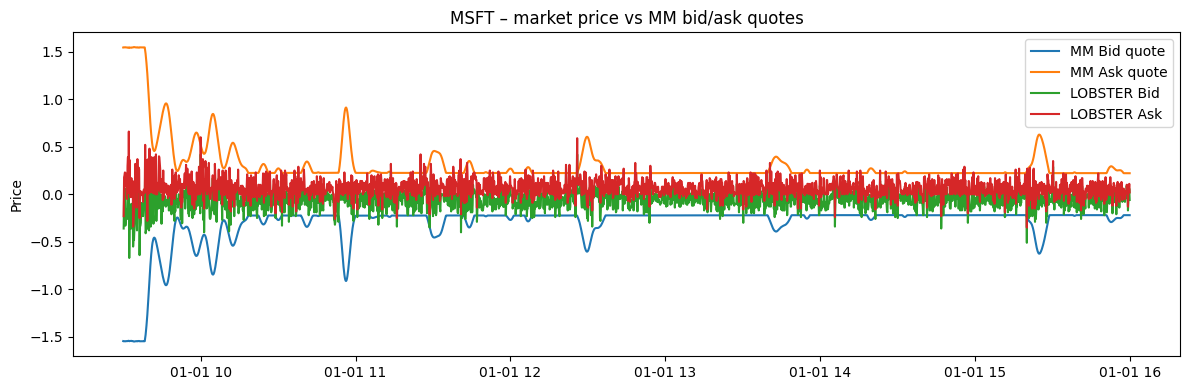

In [313]:
ticker_to_plot = "MSFT"

quotes_plot_df = visu.get_quotes_df(mm,ticker_to_plot)
inventory_df = visu.get_inventory_df(mm,ticker_to_plot)

#all_quotes = pd.merge_asof(quotes_plot_df,df_prices[['Bid','Ask']],left_index = True, right_index=True)
all_quotes = pd.merge_asof(quotes_plot_df,df_prices[['Bid','Ask']],left_index = True, right_index=True)

(fig,ax) = plt.subplots(figsize = (12,4))

ax.plot(all_quotes.index, all_quotes["bid_price"]-all_quotes['ref_price'], label="MM Bid quote")
ax.plot(all_quotes.index, all_quotes["offer_price"]-all_quotes['ref_price'], label="MM Ask quote")
ax.plot(all_quotes.index, all_quotes["Bid"]-all_quotes['ref_price'], label="LOBSTER Bid")
ax.plot(all_quotes.index, all_quotes["Ask"]-all_quotes['ref_price'], label="LOBSTER Ask")

ax.set_title(f"{ticker} – market price vs MM bid/ask quotes")
ax.set_ylabel("Price")
ax.legend()
plt.tight_layout()
plt.show()


## LOB aware + Squewed quotes

**skew definition** : 

We now define $\Delta$ Taking into account the curent bid ask spread in the market

$\Delta^{mkt}_{t}= Ask_{t}^{\,LOB} - Bid_{t}^{\,LOB}$

$\Delta_{t}^{\,base} = \max \Big( \Delta^{mkt}_t,\; mid_t \cdot \Delta_{\text{base}} \Big)
\quad \text{avec } \quad
\Delta_{\text{base}} = 2 \cdot 10^{-4} \quad \text{par exemple}$

And still use the same inventory skew

$I_t = tanh( \lambda * \frac{q_t}{q^*} )$ with $\lambda$ sensitivity, $q^*$ inventory_ideal_size, $q_t$ current inventory

$Bid_t = Mid_t \times (1 - \frac{\Delta_t}{2} - I_t)$

$Bid_t = Mid_t \times (1 + \frac{\Delta_t}{2} + I_t)$

In [230]:
def Lob_Skew_quote(current_price,base_spread,
                          inventory, inventory_ideal_size,
                          bid_lob, ask_lob,
                          sensitivity=1, max_skew=0.02):
    """
    mid       : mid LOB
    bid_lob   : best bid LOB
    ask_lob   : best ask LOB
    sigma     : vol (par ex. realised intraday)
    """
    # base spread min = max(spread LOB, k * sigma)
    mkt_spread = ask_lob - bid_lob
    spread = max(mkt_spread, current_price * base_spread)
    
    # Inventory skew 
    raw_skew = sensitivity * inventory / inventory_ideal_size
    skew = current_price * max_skew * np.tanh(raw_skew)
    bid_price = current_price + skew - spread / 2
    offer_price = current_price + skew + spread / 2

    # si tu veux rester dans [bid_lob-ε, ask_lob+ε]
    #eps = 0.0
    #bid = min(current_price, ask_lob - eps)
    #ask = max(current_price, bid_lob + eps)

    return bid_price, offer_price
